# Example: Advanced model customisation

This notebook covers an example on how to find functionality in hardware for a more complex task that requires more advanced usage of custom models. It will cover an example with the famous LeNet neural network architecture for the classical classification benchmark task of digit recognition with the Modified National Institute of Standards and Technology (MNIST) dataset.  


**Prerequisites:**
- You have a surrogate model from a DNPU model that is still connected to an NI device in the lab
    
    

In [1]:
from IPython.display import Image
from IPython.core.display import HTML

# Image from https://www.codexa.net/cnn-mnist-keras-beginner/
Image(url= "4.finding_functionality/cnn_main.png")

## 1. Having a look at the data

In [2]:
from torchvision.datasets import MNIST

# Downloading dataset in ./tmp/data
dataset_example = MNIST('./tmp/data', train=True, download=True)

/home/unai/anaconda3/envs/notebooks/lib/python3.10/site-packages/tqdm-4.64.1-py3.10.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1.1 Images

In [3]:
dataset_example

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./tmp/data
    Split: Train

In [4]:
first_dataset_element = dataset_example[0]

In [5]:
type(first_dataset_element)

tuple

In [6]:
first_dataset_element

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [7]:
first_img = first_dataset_element[0]

In [8]:
first_img

In [9]:
import numpy as np

first_img_np = np.array(first_img)

In [10]:
first_img_np.shape

(28, 28)

In [11]:
first_img_np.min()

0

In [12]:
first_img_np.max()

255

In [13]:
first_img_np

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [14]:
first_img_np/255

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

### 1.2 Image modifications

In [15]:
labelled_values = []
desired_label = 5
for i in range(len(dataset_example)):
    current = dataset_example[i]
    if current[1] == desired_label:
        labelled_values.append(np.array(current[0]))

labelled_values = np.array(labelled_values)

In [16]:
labelled_values.shape

(5421, 28, 28)

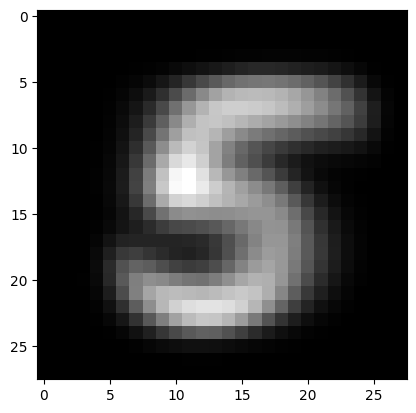

In [17]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(labelled_values.mean(0),cmap='gray')
plt.show()

### 1.3 Labels and One-hot encoding

In [18]:
first_label = first_dataset_element[1]

In [19]:
first_label

5

In [20]:
first_label_one_hot = np.zeros(10)
first_label_one_hot[first_label] = 1
first_label_one_hot

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Note that the model should also produce outputs that are a vector with the same dimension as the number of labels. In this case 10

## 2. Understanding loss functions

The cross entropy loss function can be decomposed into Softmax and Negative Likelihood. We can have a look at these concepts individually.

### 2.1 Softmax

We want to represent the raw output of our model (logits) as a probability, for which it would need to satisfy the following conditions:
- Each element in $\hat{y_i}$ is in a range from 0 to 1. 
- All the elements of the output prediction vector $\hat{y_i}$ add to 1.
- It maintains this ratio when translating it into a probability. I.e. if a if one value in $\hat{y_i}$ is greater, it should maintain its proportion. 

In principle, we could try to satisfy these conditions by dividing each of the elements in the output vector prediction $\hat{y_i}$ by the sum of all the elements in the same vector. 

$ f({y_i}) = \frac{\hat{y_{ij}}}{\sum_{j=0}^{n} \hat{y_{ij}}} $

In [21]:
y_i_hat = np.array([3,2,1])

In [22]:
f = []
for i in range(len(y_i_hat)):
    f.append(y_i_hat[i] / y_i_hat.sum())
    print(f[-1])

0.5
0.3333333333333333
0.16666666666666666


In [23]:
np.array(f).sum()

0.9999999999999999

However, if we have negative values, we could end with NaN values. In order to maintain numerical stability, we can turn all negative values into positive ones we use the function $e^x$. Making the softmax function formula be: 

$  f({y_i}) = \frac{e^{\hat{y_{ij}}}}{\sum_{j=0}^{n} e^{\hat{y_{ij}}}} $

In [24]:

f = []
for i in range(len(y_i_hat)):
    f.append( np.exp(y_i_hat[i]) / np.exp(y_i_hat).sum())
    print(f[-1])

0.6652409557748219
0.24472847105479764
0.09003057317038045


In [25]:

np.array(f).sum()

1.0

Where n is the number of classes in the dataset. $\hat{y_i}$ is a prediction vector of the same size as the number of classes. The model should maintain the same vector lenghth as the target values. Remember that we have already seen an example of how target vectors look like for the number 5:

In [26]:
first_label_one_hot

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Finally, the division can be made more numerically stable (avoiding division by zero), when transformed into the log domain, where it would be a substraction. Therefore, 
it is not uncommon to use $log(f(y_i))$ instead. This other function is called log softmax.

In [27]:
# Source from https://www.youtube.com/watch?v=RC_A9Tu99y4

### 2.2 Maximum likelihood

The goal of maximum likelihood is to find a distribution that maximises the likelihood of observing the outputs that are measured. Therefore, it assigns higher probabilities to models that are able to represent probabilities based on what was observed and picks the model that gives existing labels the highest probability. 

To understand this better, let us assume that we have a simple perceptron  $\hat{y}$ = $\sigma$(W*x + b) that classifies four points (two blue and two red). Our particular prediction $\hat{y}$ is equal to the probability of a particular point being labelled correctly $P$(blue) = $\sigma$(W*x + b). Let us assume that you have two different models, giving you different probabilities for the same points. The first model is represented on the left of the image, and the second model is represented on the right of the image below. The images show the probability of being red in red, and the probability of being blue in blue. Note that the probability of being blue is one minus the probability of being red. Assuming that the points are independent events, then the probability for the whole arrangement is the product of the probabilities of each point.

In [28]:
from IPython.display import Image
from IPython.core.display import HTML

# Image and lesson from https://www.youtube.com/watch?v=6nUUeQ9AeUA
Image(url= "4.finding_functionality/likelihood.png")

In [29]:
-(np.log(0.6) + np.log(0.2) + np.log(0.1) + np.log(0.7))

4.779523573132869

In [30]:
-(np.log(0.7) + np.log(0.9) + np.log(0.8) + np.log(0.6))

1.1960046346767592

### 2.3 Binary cross entropy

We want to maximise the likelihood of a model, but for this we need to multiply many points, which is inconvenient when we have huge datasets. In order to make products into sums, we use log functions. Probabilities are expressed in a range from 0 to 1, but on log scale these values are negative, so we take the negative log of the probabilities. Lower cross entropy is better than higher. The final formula for cross entropy is:

$- \sum_{i=0}^{m} y_i . ln(p_i) + (1 - y_i) . ln(1 - p_i)$

Where m is the number of elements in the dataset.

### 2.4 Multi-class cross entropy

In a very similar way, this concept can be extended to multi classes.

$- \sum_{j=0}^{n} \sum_{i=0}^{m} y_{ij} . ln(p_{ij})$

Where n is the number of classes in the dataset. $\hat{y_i}$ is a prediction vector of the same size as the number of classes. The model should maintain the same vector lenghth as the target values. Remember that we have already seen an example of how target vectors look like for the number 5:

In [31]:
first_label_one_hot

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

## 3. Preparing the data

## 4. Preparing the training loop

In [32]:
import pytorch_lightning as pl
from torch.utils.data import random_split

from torch.jit.annotations import Optional
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self,
                 data_dir: str = "./tmp/data",
                 batch_size: int = 32,
                 num_workers=4,
                 pin_memory=False,
                 split=[55000, 5000]):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.pin_memory = pin_memory
        self.split = split

    def prepare_data(self):
        # download
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        if stage == 'fit' or stage is None:
            mnist_full = MNIST(self.data_dir,
                               train=True,
                               transform=transforms.ToTensor())
            self.mnist_train, self.mnist_val = random_split(
                mnist_full, self.split)
        if stage == 'test' or stage is None:
            self.mnist_test = MNIST(self.data_dir,
                                    train=False,
                                    transform=transforms.ToTensor())

    def train_dataloader(self):
        return DataLoader(self.mnist_train,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=True,
                          pin_memory=self.pin_memory)

    def val_dataloader(self):
        return DataLoader(self.mnist_val,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False,
                          pin_memory=self.pin_memory)

    def test_dataloader(self):
        return DataLoader(self.mnist_test,
                          batch_size=self.batch_size,
                          num_workers=self.num_workers,
                          shuffle=False,
                          pin_memory=self.pin_memory)

In [33]:
import pytorch_lightning as pl

import torch
import torch.nn.functional as F

from torchmetrics.functional.classification.accuracy import accuracy

from pytorch_lightning.callbacks import ModelCheckpoint


class TrainerMNIST(pl.LightningModule):
    def __init__(self, model, batch_size, learning_rate=1e-3):
        super(TrainerMNIST, self).__init__()
        self.name = 'mnist_trainer'
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return opt

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def shared_step(self, batch):
        x, y = batch
        preds = self(x)
        loss = F.nll_loss(preds, y)
        acc = accuracy(preds, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch)
        self.log('loss_epoch', {'train': loss}, on_step=False, on_epoch=True)
        self.log('acc_epoch', {'train': acc}, on_step=False, on_epoch=True)
        self.log('train_loss', loss, prog_bar=False)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch)
        self.log('loss_epoch', {'val': loss}, on_step=False, on_epoch=True)
        self.log('acc_epoch', {'val': acc}, on_step=False, on_epoch=True)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch)
        self.log('loss_epoch', {'test': loss}, on_step=False, on_epoch=True)
        self.log('acc_epoch', {'test': acc}, on_step=False, on_epoch=True)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    # Allow brains-py to do constrained optimisation
    def training_step_end(self, outputs):
        if 'constraint_weights' in dir(self.model):
            self.model.constraint_weights()
        return outputs
    
    # Make pretty the progress bar
    def get_progress_bar_dict(self):
        # don't show the version number
        items = super().get_progress_bar_dict()
        items.pop("v_num", None)
        return items


## 5. Creating a vanilla pytorch model

A custom model can be created in pytorch by implementing a child class of nn.Module

In [34]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url= "4.finding_functionality/lenet3.jpg")

In [35]:
from torch import nn

class FlattenView(nn.Module):
    def __init__(self):
        super(FlattenView, self).__init__()

    def forward(self, x):

        #return x.view(x.shape[0], -1)
        return x.flatten(1, -1)

In [36]:
from torch import nn

class LeNet(nn.Module):
    
    # Constructor: Initialisation stage
    def __init__(self, mode='nn'):
        super(LeNet, self).__init__()
        self.name = 'LeNet'

        # First convolution layer
        #                     (in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1          ,6            , 3)
        
        
        # Second convolution layer
        #                     (in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(6          ,16           , 3)
        
        # Fully connected layer
        self.fc = nn.Sequential(FlattenView(), 
                                nn.Linear(400, 120),
                                nn.ReLU(), 
                                nn.Linear(120, 84), 
                                nn.ReLU(),
                                nn.Linear(84, 10))
        # Activation function
        self.act = nn.ReLU()
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        
        x = self.fc(x)
        
        return x # Logits

## 6. Training the vanilla model

### Hyperparemeters

In [37]:
batch_size = 64
lr = 1e-3

### Seed

In [38]:
from pytorch_lightning import seed_everything

seed = 2508835240
seed = seed_everything(seed, workers=True)

Global seed set to 2508835240


In [39]:
mnist = MNISTDataModule(batch_size=batch_size)

In [40]:
checkpoint_callback = ModelCheckpoint(
        monitor='val_acc', filename='sample-mnist-{val_acc:.3f}', mode='max')

In [41]:
model = LeNet()

In [42]:
model_wrapper = TrainerMNIST(model, batch_size=batch_size, learning_rate=lr)

In [43]:
trainer = pl.Trainer(gpus=0,max_epochs=5,
    callbacks=[checkpoint_callback],
    deterministic=True)

/home/unai/anaconda3/envs/notebooks/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/unai/anaconda3/envs/notebooks/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [44]:
%load_ext tensorboard
%tensorboard --logdir=lightning_logs

In [45]:
trainer.fit(model_wrapper, datamodule=mnist)

Missing logger folder: /home/unai/Documents/3-Programming/bspy/tasks/notebooks/lightning_logs

  | Name  | Type  | Params
--------------------------------
0 | model | LeNet | 60.1 K
--------------------------------
60.1 K    Trainable params
0         Non-trainable params
60.1 K    Total params
0.240     Total estimated model params size (MB)


Epoch 0:  92%|███▋| 860/939 [00:09<00:00, 89.68it/s, loss=0.152, v_num=0, train_acc=0.958]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███▉| 938/939 [00:10<00:00, 90.51it/s, loss=0.152, v_num=0, train_acc=0.958]
Epoch 0: 100%|█| 939/939 [00:10<00:00, 90.51it/s, loss=0.152, v_num=0, train_acc=0.958, va
Epoch 1:  92%|▉| 860/939 [00:10<00:00, 83.76it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                     | 0/79 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 861/939 [00:10<00:00, 82.83it/s, loss=0.0831, v_num=0, train_acc=0.958, v


Epoch 1:  92%|▉| 862/939 [00:10<00:00, 82.84it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 863/939 [00:10<00:00, 82.84it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 864/939 [00:10<00:00, 82.88it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 865/939 [00:10<00:00, 82.91it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 866/939 [00:10<00:00, 82.95it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 867/939 [00:10<00:00, 82.98it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  92%|▉| 868/939 [00:10<00:00, 83.01it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  93%|▉| 869/939 [00:10<00:00, 83.04it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  93%|▉| 870/939 [00:10<00:00, 83.07it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  93%|▉| 871/939 [00:10<00:00, 83.09it/s, loss=0.0831, v_num=0, train_acc=0.958, v
Epoch 1:  93%|▉| 872/939 [00:10<00:00, 83.12it/s, loss=0.0831, v_num=0, train_acc=0.958, v

Epoch 2:  92%|▉| 866/939 [00:10<00:00, 79.39it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  92%|▉| 867/939 [00:10<00:00, 79.43it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  92%|▉| 868/939 [00:10<00:00, 79.46it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 869/939 [00:10<00:00, 79.49it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 870/939 [00:10<00:00, 79.51it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 871/939 [00:10<00:00, 79.53it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 872/939 [00:10<00:00, 79.57it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 873/939 [00:10<00:00, 79.60it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 874/939 [00:10<00:00, 79.61it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 875/939 [00:10<00:00, 79.64it/s, loss=0.0616, v_num=0, train_acc=1.000, v
Epoch 2:  93%|▉| 876/939 [00:10<00:00, 79.67it/s, loss=0.0616, v_num=0, train_acc=1.000, v

Epoch 3:  93%|▉| 870/939 [00:12<00:00, 69.20it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 871/939 [00:12<00:00, 69.22it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 872/939 [00:12<00:00, 69.24it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 873/939 [00:12<00:00, 68.67it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 874/939 [00:12<00:00, 68.71it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 875/939 [00:12<00:00, 68.74it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 876/939 [00:12<00:00, 68.77it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  93%|▉| 877/939 [00:12<00:00, 68.80it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  94%|▉| 878/939 [00:12<00:00, 68.83it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  94%|▉| 879/939 [00:12<00:00, 68.86it/s, loss=0.04, v_num=0, train_acc=0.958, val
Epoch 3:  94%|▉| 880/939 [00:12<00:00, 68.89it/s, loss=0.04, v_num=0, train_acc=0.958, val

Epoch 4:  93%|▉| 874/939 [00:13<00:00, 66.49it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  93%|▉| 875/939 [00:13<00:00, 66.48it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  93%|▉| 876/939 [00:13<00:00, 66.50it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  93%|▉| 877/939 [00:13<00:00, 66.52it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 878/939 [00:13<00:00, 66.54it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 879/939 [00:13<00:00, 66.56it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 880/939 [00:13<00:00, 66.58it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 881/939 [00:13<00:00, 66.60it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 882/939 [00:13<00:00, 66.62it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 883/939 [00:13<00:00, 66.64it/s, loss=0.0542, v_num=0, train_acc=1.000, v
Epoch 4:  94%|▉| 884/939 [00:13<00:00, 66.66it/s, loss=0.0542, v_num=0, train_acc=1.000, v

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 939/939 [00:13<00:00, 67.43it/s, loss=0.0542, v_num=0, train_acc=1.000, v


## 6. Modifying LeNet

In [46]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url= "4.finding_functionality/lenetmodified.jpg")

In [47]:
from torch import nn

class LeNetModified(nn.Module):
    
    # Constructor: Initialisation stage
    def __init__(self, mode='nn'):
        super(LeNetModified, self).__init__()
        self.name = 'LeNetModified'

        # First convolution layer
        #                     (in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1          ,6            , 3)
        self.bn1 = nn.BatchNorm2d(6) # Same as out channels
        
        # Second convolution layer
        #                     (in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(6          ,16           , 3)
        self.bn2 = nn.BatchNorm2d(16) # Same as out channels
        
        # Fully connected layer
        self.fc = nn.Sequential(FlattenView(), 
                                nn.Linear(400, 120),
                                nn.ReLU(), 
                                nn.Linear(120, 84), 
                                nn.ReLU(),
                                nn.Linear(84, 10))
        # Activation function
        self.act = nn.Sigmoid() # Changed activation function
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x) # New line
        x = self.act(x) 
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x) # New line
        x = self.act(x)
        x = self.pool(x)
        
        x = self.fc(x)
        
        return x # Logits

In [48]:
model_modified = LeNetModified()
model_modified_wrapper = TrainerMNIST(model_modified, batch_size=batch_size, learning_rate=lr)
trainer = pl.Trainer(gpus=1,max_epochs=5,
    callbacks=[checkpoint_callback],
    deterministic=True)
trainer.fit(model_modified_wrapper, datamodule=mnist)

/home/unai/anaconda3/envs/notebooks/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/unai/anaconda3/envs/notebooks/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/unai/Documents/3-Programming/bspy/tasks/notebooks/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type          | Params
----------------------------------------
0 | model | LeNetModified | 60.1 K
------------------------

Epoch 0:  92%|███▋| 860/939 [00:10<00:00, 85.98it/s, loss=0.185, v_num=1, train_acc=1.000]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███▉| 938/939 [00:10<00:00, 85.78it/s, loss=0.185, v_num=1, train_acc=1.000]
Epoch 0: 100%|█| 939/939 [00:10<00:00, 85.75it/s, loss=0.185, v_num=1, train_acc=1.000, va
Epoch 1:  92%|▉| 860/939 [00:10<00:00, 84.91it/s, loss=0.15, v_num=1, train_acc=0.917, val
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                                     | 0/79 [00:00<?, ?it/s]
Epoch 1:  92%|▉| 861/939 [00:10<00:00, 83.50it/s, loss=0.15, v_num=1, train_acc=0.917, val


Epoch 1:  92%|▉| 862/939 [00:10<00:00, 83.52it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 863/939 [00:10<00:00, 83.56it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 864/939 [00:10<00:00, 83.56it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 865/939 [00:10<00:00, 83.61it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 866/939 [00:10<00:00, 83.63it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 867/939 [00:10<00:00, 83.68it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  92%|▉| 868/939 [00:10<00:00, 83.68it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  93%|▉| 869/939 [00:10<00:00, 83.72it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  93%|▉| 870/939 [00:10<00:00, 83.74it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  93%|▉| 871/939 [00:10<00:00, 83.77it/s, loss=0.15, v_num=1, train_acc=0.917, val
Epoch 1:  93%|▉| 872/939 [00:10<00:00, 83.80it/s, loss=0.15, v_num=1, train_acc=0.917, val

Epoch 2:  92%|▉| 866/939 [00:10<00:00, 85.28it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  92%|▉| 867/939 [00:10<00:00, 85.30it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  92%|▉| 868/939 [00:10<00:00, 85.32it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 869/939 [00:10<00:00, 85.36it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 870/939 [00:10<00:00, 85.39it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 871/939 [00:10<00:00, 85.42it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 872/939 [00:10<00:00, 85.46it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 873/939 [00:10<00:00, 85.49it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 874/939 [00:10<00:00, 85.52it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 875/939 [00:10<00:00, 85.53it/s, loss=0.11, v_num=1, train_acc=0.958, val
Epoch 2:  93%|▉| 876/939 [00:10<00:00, 85.57it/s, loss=0.11, v_num=1, train_acc=0.958, val

Epoch 3:  93%|▉| 870/939 [00:10<00:00, 84.20it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 871/939 [00:10<00:00, 84.22it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 872/939 [00:10<00:00, 84.24it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 873/939 [00:10<00:00, 84.26it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 874/939 [00:10<00:00, 84.27it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 875/939 [00:10<00:00, 84.30it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 876/939 [00:10<00:00, 84.33it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  93%|▉| 877/939 [00:10<00:00, 84.35it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  94%|▉| 878/939 [00:10<00:00, 84.37it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  94%|▉| 879/939 [00:10<00:00, 84.39it/s, loss=0.0594, v_num=1, train_acc=1.000, v
Epoch 3:  94%|▉| 880/939 [00:10<00:00, 84.42it/s, loss=0.0594, v_num=1, train_acc=1.000, v

Epoch 4:  93%|▉| 874/939 [00:11<00:00, 78.29it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  93%|▉| 875/939 [00:11<00:00, 78.30it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  93%|▉| 876/939 [00:11<00:00, 78.31it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  93%|▉| 877/939 [00:11<00:00, 78.35it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 878/939 [00:11<00:00, 78.38it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 879/939 [00:11<00:00, 78.41it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 880/939 [00:11<00:00, 78.43it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 881/939 [00:11<00:00, 78.45it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 882/939 [00:11<00:00, 78.48it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 883/939 [00:11<00:00, 78.48it/s, loss=0.0869, v_num=1, train_acc=0.958, v
Epoch 4:  94%|▉| 884/939 [00:11<00:00, 78.51it/s, loss=0.0869, v_num=1, train_acc=0.958, v

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|█| 939/939 [00:11<00:00, 79.75it/s, loss=0.0869, v_num=1, train_acc=0.958, v


For this exercise, the Genetic Algorithm will be used, as this is a fast way to explore functionality on devices directly on-chip. The particularities of each config is explained below.

## 7. Using convolutions with DNPUs

In [49]:
def get_node_configs():
    configs = {}
    configs["model_data_path"] = "./training_data.pt"  # "./tmp/models/training_data_new_without_clipping.pt"  #"./tmp/models/training_data.pt"
    configs["processor_type"] = "simulation"
    configs["waveform"] = {}
    configs["waveform"]["plateau_length"] = 1
    configs["waveform"]["slope_length"] = 0
    return configs

In [50]:
from torch import nn
from brainspy.processors.processor import Processor
from brainspy.processors.modules.conv import DNPUConv2d

class LeNetDNPU(nn.Module):
    
    # Constructor: Initialisation stage
    def __init__(self, mode='nn'):
        super(LeNetDNPU, self).__init__()
        self.name = 'LeNetDNPU'
        
        ###############################################################
        # Declare a processor
        configs = get_node_configs()
        model_data = torch.load(configs['model_data_path'])
        self.processor_base = Processor(configs, model_data['info'],
                         model_data['model_state_dict'])
        
        # Select data input indices of each DNPU
        data_input_indices_list = [[2, 3, 4]] * 3
        ###############################################################
        
        # First convolution layer
        #            nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = DNPUConv2d(self.processor_base, data_input_indices_list,
                               1          ,6            , 3)
        self.bn1 = nn.BatchNorm2d(6) # Same as out channels
        
        # Second convolution layer
        #            nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv2 = DNPUConv2d(self.processor_base, data_input_indices_list,
                               6          ,16            , 3)
        self.bn2 = nn.BatchNorm2d(16) # Same as out channels
        
        # Fully connected layer
        self.fc = nn.Sequential(FlattenView(), 
                                nn.Linear(400, 120),
                                nn.ReLU(), 
                                nn.Linear(120, 84), 
                                nn.ReLU(),
                                nn.Linear(84, 10))
        # Activation function
        self.act = nn.Sigmoid() # Changed activation function
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        ###############################################################
        self.conv1.add_input_transform([0, 1])
        self.conv2.add_input_transform([0, 1])
        ###############################################################
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x) # New line
        x = self.act(x) 
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.bn2(x) # New line
        x = self.act(x)
        x = self.pool(x)
        
        x = self.fc(x)
        
        return x # Logits
    
    ###############################################################
    def swap(self, configs, info):
        self.processor_base.swap(configs, info)
    ###############################################################
        
        

In [ ]:
batch_size = 2

model_modified = LeNetDNPU().to('cpu')
model_modified_wrapper = TrainerMNIST(model_modified, batch_size=batch_size, learning_rate=lr).to('cpu')

trainer = pl.Trainer(gpus=0, max_epochs=5,
    callbacks=[checkpoint_callback],
    deterministic=True)

trainer.fit(model_modified_wrapper, datamodule=mnist)